<a href="https://colab.research.google.com/github/YABIGAIL23/INVESTIGACI-N-DE-OPERACIONES/blob/main/Inventario_de_varios_art%C3%ADculos_con_limitaci%C3%B3n_de_almac%C3%A9n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color="red">Inventario de varios artículos con limitación de almacén</font>

Yael Abigail Rodriguez Olivares

**Instrucciones**

Elaborar una notebook que implemente el modelo "Cantidad económica de pedido de varios artículos con limitación de almacén". La referencia es la Sección 11.2.3 del libro Investigación de Operaciones de Taha, séptima edición.

Escriba un código que implemente los 3 pasos del método, usando las librerías sympy y scipy. Use el ejemplo 11.2-3 del libro como ejemplo de prueba.

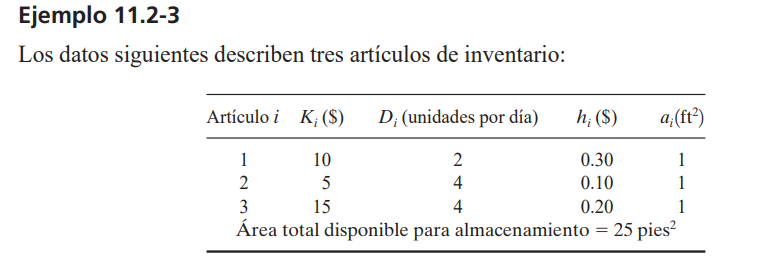

Minimizar **$TCU(y_1, y_2,...,y_n)$**$=∑(\frac{K_i D_i}{ y_i} + \frac{h_i y_i}{2})$

sujeto a

$∑ a_i y_i ≤ A$

con $y_i>0, i=1,2,...,n$

In [27]:
#Librerias
import numpy as np
import sympy as sp
import scipy.optimize as opt

In [28]:
#Símbolos
lam = sp.Symbol('lam', real=True)
Ki, Di, hi, ai = sp.symbols('Ki Di hi ai', positive=True, real=True)

#y(lam) según condiciones de Lagrange del libro:
#-KiDi/yi^2 + hi/2 - lam*ai = 0  => yi = sqrt(2KiDi / (hi - 2 lam ai))
y_lam_expr = sp.sqrt( (2*Ki*Di) / (hi - 2*lam*ai) )

In [29]:
y_lam_expr


sqrt(2)*sqrt(Di)*sqrt(Ki)*sqrt(1/(-2*ai*lam + hi))

In [30]:
#Modelo EOQ de varios artículos con restricción de almacén
def eoq_multi_almacen(K, D, h, a, A, tol=1e-9):

    K = np.array(K, dtype=float)
    D = np.array(D, dtype=float)
    h = np.array(h, dtype=float)
    a = np.array(a, dtype=float)

    n = len(K) #Tamano de k

  #Paso 1 y_i*

    y_star = np.sqrt(2*K*D/h)

  #Paso 2 verificar restricción

    uso = np.sum(a * y_star)
    if uso <= A + tol:
        #No se activa la restricción
        lam_opt = 0.0
        return y_star, lam_opt, False

  #Paso 3 Lagrange, resolver λ

    #Construimos función y_i(lam) con la fórmula simbólica y lambdify
    y_num = sp.lambdify((lam, Ki, Di, hi, ai), y_lam_expr, 'numpy')

    def y_vec(lam_val):
        denom = h - 2*lam_val*a
        #dominio: denom > 0 para todos
        if np.any(denom <= 0):
            return None
        return y_num(lam_val, K, D, h, a)

    def g(lam_val):
        yv = y_vec(lam_val)
        if yv is None:
            #fuera del dominio, devolvemos algo "grande" con signo que ayude al bracket
            return 1e9
        return np.sum(a * yv) - A

    #Necesitamos encontrar un intervalo [lam_lo, lam_hi] donde g cambie de signo.
    #Observación del libro: λ < 0 en este planteamiento (porque está como -λ(...)).
    lam_hi = 0.0   #g(0) > 0 (porque violó)
    lam_lo = -1.0  #intentamos negativo

    #Expandimos hacia la izquierda hasta lograr g(lam_lo) < 0
    while g(lam_lo) > 0:
        lam_lo *= 2.0
        if lam_lo < -1e6:
            raise RuntimeError("No se pudo encontrar bracket para λ (muy negativo). Revisa datos.")

    sol = opt.root_scalar(g, bracket=[lam_lo, lam_hi], method='bisect', xtol=tol)

    lam_opt = sol.root
    y_opt = y_vec(lam_opt)

    return y_opt, lam_opt, True

In [31]:
K = [10, 5, 15]
D = [2, 4, 4]
h = [0.30, 0.10, 0.20]
a = [1, 1, 1]
A = 25

In [32]:
y_opt, lam_opt, activa = eoq_multi_almacen(K, D, h, a, A)

In [33]:
print("¿Restricción activa?:", activa)
print("lambda óptimo =", lam_opt)
print("y óptimo =", y_opt)
print("Uso de almacén sum(a_i*y_i) =", np.sum(np.array(a)*y_opt))


¿Restricción activa?: True
lambda óptimo = -0.3479576325044036
y óptimo = [ 6.33751209  7.08918939 11.57329851]
Uso de almacén sum(a_i*y_i) = 24.999999984846724


In [34]:
y_star = np.sqrt(2*np.array(K)*np.array(D)/np.array(h))
print("y* no restringido =", y_star)
print("Uso no restringido =", np.sum(np.array(a)*y_star), "  (A =", A, ")")

y* no restringido = [11.54700538 20.         24.49489743]
Uso no restringido = 56.0419028116243   (A = 25 )


In [35]:
def TCU(y, K, D, h):
    y = np.array(y, dtype=float)
    return np.sum((np.array(K)*np.array(D))/y + (np.array(h)*y)/2)

def restriccion_almacen(y, a, A):
    # ineq en scipy: fun(x) >= 0
    # A - sum(a_i y_i) >= 0  (equivale a sum(a_i y_i) <= A)
    return A - np.sum(np.array(a)*np.array(y))

In [36]:
K = np.array([10, 5, 15], dtype=float)
D = np.array([2, 4, 4], dtype=float)
h = np.array([0.30, 0.10, 0.20], dtype=float)
a = np.array([1, 1, 1], dtype=float)
A = 25.0

# Punto inicial: EOQ no restringido
y0 = np.sqrt(2*K*D/h)

# Si viola la restricción, lo escalamos para que cumpla (mismo "shape", menor tamaño)
uso0 = np.sum(a*y0)
if uso0 > A:
    y0 = y0 * (A/uso0)  # escala para que sum(a*y0)=A

# Restricciones para SLSQP
cons = (
    {'type': 'ineq', 'fun': lambda y: restriccion_almacen(y, a, A)},
)

# Bounds para asegurar y_i > 0 (por ejemplo, mínimo 1e-9)
bnds = tuple((1e-9, None) for _ in range(len(K)))

sol_scipy = opt.minimize(
    fun=lambda y: TCU(y, K, D, h),
    x0=y0,
    method="SLSQP",
    bounds=bnds,
    constraints=cons
)

sol_scipy

     message: Optimization terminated successfully
     success: True
      status: 0
         fun: 13.623773077481385
           x: [ 6.337e+00  7.089e+00  1.157e+01]
         nit: 10
         jac: [-3.480e-01 -3.480e-01 -3.479e-01]
        nfev: 40
        njev: 10
 multipliers: [ 3.480e-01]

In [37]:
y_lagr, lam_opt, activa = eoq_multi_almacen(K, D, h, a, A)

In [38]:
print("=== Método 3 pasos (Lagrange) ===")
print("Restricción activa?:", activa)
print("lambda óptimo =", lam_opt)
print("y (Lagrange) =", y_lagr)
print("Uso almacén =", np.sum(a*y_lagr))
print("TCU =", TCU(y_lagr, K, D, h))

print("\n=== SciPy minimize (SLSQP) ===")
print("Éxito?:", sol_scipy.success)
print("Mensaje:", sol_scipy.message)
print("y (SciPy) =", sol_scipy.x)
print("Uso almacén =", np.sum(a*sol_scipy.x))
print("TCU =", TCU(sol_scipy.x, K, D, h))

print("\n=== Diferencia (SciPy - Lagrange) ===")
print(sol_scipy.x - y_lagr)

=== Método 3 pasos (Lagrange) ===
Restricción activa?: True
lambda óptimo = -0.3479576325044036
y (Lagrange) = [ 6.33751209  7.08918939 11.57329851]
Uso almacén = 24.999999984846724
TCU = 13.623773075113938

=== SciPy minimize (SLSQP) ===
Éxito?: True
Mensaje: Optimization terminated successfully
y (SciPy) = [ 6.33734658  7.08903057 11.57362285]
Uso almacén = 25.0
TCU = 13.623773077481385

=== Diferencia (SciPy - Lagrange) ===
[-0.00016551 -0.00015882  0.00032434]


In [39]:
def suma_area_lambda(lam_val, K, D, h, a):
    denom = h - 2*lam_val*a
    if np.any(denom <= 0):
        return np.nan
    y = np.sqrt(2*K*D / denom)
    return np.sum(a * y)

In [40]:
lam_vals = np.linspace(lam_opt*1.5, 0.0, 300)
area_vals = [suma_area_lambda(l, K, D, h, a) for l in lam_vals]

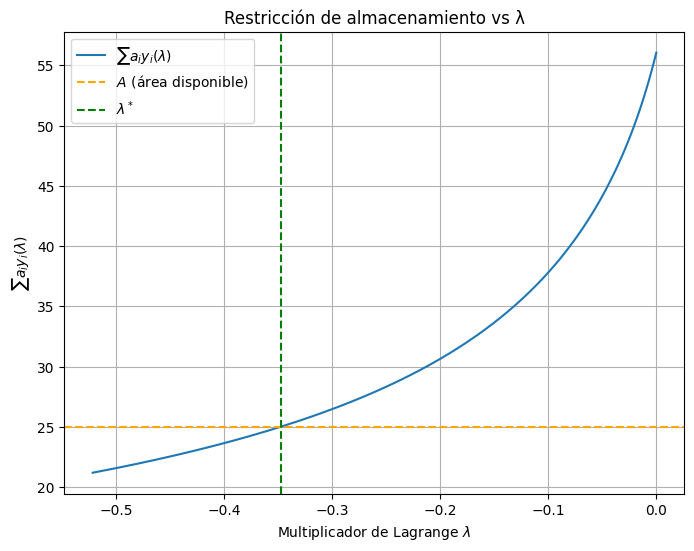

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))

plt.plot(lam_vals, area_vals, label=r'$\sum a_i y_i(\lambda)$')
plt.axhline(A, color='orange', linestyle='--', label=r'$A$ (área disponible)')
plt.axvline(lam_opt, color='green', linestyle='--', label=r'$\lambda^*$')

plt.xlabel(r'Multiplicador de Lagrange $\lambda$')
plt.ylabel(r'$\sum a_i y_i(\lambda)$')
plt.title('Restricción de almacenamiento vs λ')
plt.legend()
plt.grid(True)

plt.show()